In [2]:
%%capture stored_output
%load_ext autoreload
%autoreload 2

In [3]:
import d3rlpy
from d3rlpy.metrics.scorer import (
    average_value_estimation_scorer,
    td_error_scorer,
    evaluate_on_environment,
    discounted_sum_of_advantage_scorer,
    initial_state_value_estimation_scorer,
    
)
import seaborn as sns
import pandas as pd
import itertools

import warnings

warnings.filterwarnings("ignore")

import os

os.chdir("..")

from augmentation.augmented_dataset import MDPDatasetAugmented

In [4]:
os.environ["D4RL_SUPPRESS_IMPORT_ERROR"] = "1"

In [5]:
USE_GPU = True
AUGMENTATIONS = ["gaussian", "mixup"]
# epochs per environment or per algorithm?
ENVS = [
    {"name": "cartpole-replay", "discrete": True, "epochs": 1},
    #{"name": "door-human-v1", "discrete": False, "epochs": 50},
    #{"name": "halfcheetah-medium-replay-v0", "discrete": False, "epochs": 50},
    #{"name": "hopper-medium-replay-v0", "discrete": False, "epochs": 40}
]
ALGOS_C = [
    {
        "algo_class": d3rlpy.algos.BCQ,
        "scorers": {
            "td_error": td_error_scorer,
            "value_scale": average_value_estimation_scorer,
            "advantage": discounted_sum_of_advantage_scorer,
            "initial_state_value": initial_state_value_estimation_scorer
        },
    },
    {
        "algo_class": d3rlpy.algos.CQL,
        "scorers": {
            "td_error": td_error_scorer,
            "value_scale": average_value_estimation_scorer,
            "advantage": discounted_sum_of_advantage_scorer,
            "initial_state_value": initial_state_value_estimation_scorer
        },
    },
]
ALGOS_D = [
    {
        "algo_class": d3rlpy.algos.DiscreteBCQ,
        "scorers": {
            "td_error": td_error_scorer,
            "value_scale": average_value_estimation_scorer,
            "advantage": discounted_sum_of_advantage_scorer,
            "initial_state_value": initial_state_value_estimation_scorer
        },
    },
    {
        "algo_class": d3rlpy.algos.DiscreteCQL,
        "scorers": {
            "td_error": td_error_scorer,
            "value_scale": average_value_estimation_scorer,
            "advantage": discounted_sum_of_advantage_scorer,
            "initial_state_value": initial_state_value_estimation_scorer
        },
    },
]

## Training with clean and augmented datasets

In [ ]:
results = []
# TODO save best models
for env_item in ENVS:
    try:
        dataset, env = d3rlpy.datasets.get_dataset(env_item["name"])
    except ValueError:
        try:
            dataset, env = d3rlpy.datasets.get_d4rl(env_item["name"])
        except ValueError:
            continue
    augmented_dataset = MDPDatasetAugmented.from_mdpdataset(
        dataset, augmentations=AUGMENTATIONS
    )
    try_algos = ALGOS_D if env_item["discrete"] else ALGOS_C
    for algo_item in try_algos:
        algo = algo_item["algo_class"]
        agent_clean = algo(use_gpu=USE_GPU)
        agent_augmented = algo(use_gpu=USE_GPU)
        # clean training
        metrics_clean = agent_clean.fit(
            dataset,
            eval_episodes=dataset,
            n_epochs=env_item["epochs"],
            scorers=(
                algo_item["scorers"]
                | {"environment_reward": evaluate_on_environment(env, n_trials=2)}
            ),
            verbose=False,
            show_progress=False,
            experiment_name="{}_{}_{}_clean".format(
                env_item["name"], algo.__name__, env_item["epochs"]
            ),
        )
        # augmented training
        metrics_augmented = agent_augmented.fit(
            augmented_dataset,
            eval_episodes=dataset,
            n_epochs=env_item["epochs"],
            scorers=(
                algo_item["scorers"]
                | {"environment_reward": evaluate_on_environment(env, n_trials=2)}
            ),
            verbose=False,
            show_progress=False,
            experiment_name="{}_{}_{}_augmented".format(
                env_item["name"], algo.__name__, env_item["epochs"]
            ),
        )
        # easy pandasify
        for epoch, metric in metrics_clean:
            results.append(
                {
                    "env": env_item["name"],
                    "algo": "{}_clean".format(algo.__name__),
                    "epoch": epoch,
                }
                | metric
            )

        for epoch, metric in metrics_augmented:
            results.append(
                {
                    "env": env_item["name"],
                    "algo": "{}_augmented".format(algo.__name__),
                    "epoch": epoch,
                }
                | metric
            )

2022-05-30 21:56.43 [debug    ] RoundIterator is selected.
2022-05-30 21:56.43 [info     ] Directory is created at d3rlpy_logs/cartpole-replay_DiscreteBCQ_80_clean_20220530215643
2022-05-30 21:56.43 [debug    ] Building models...
2022-05-30 21:56.49 [debug    ] Models have been built.


In [ ]:
stored_output.show()

## Comparing results

In [ ]:
results_df = pd.DataFrame(results)
results_df.to_parquet("results/simple_results.parquet")

In [6]:
results_df = pd.read_parquet("results/simple_results_0.parquet")

### TD error

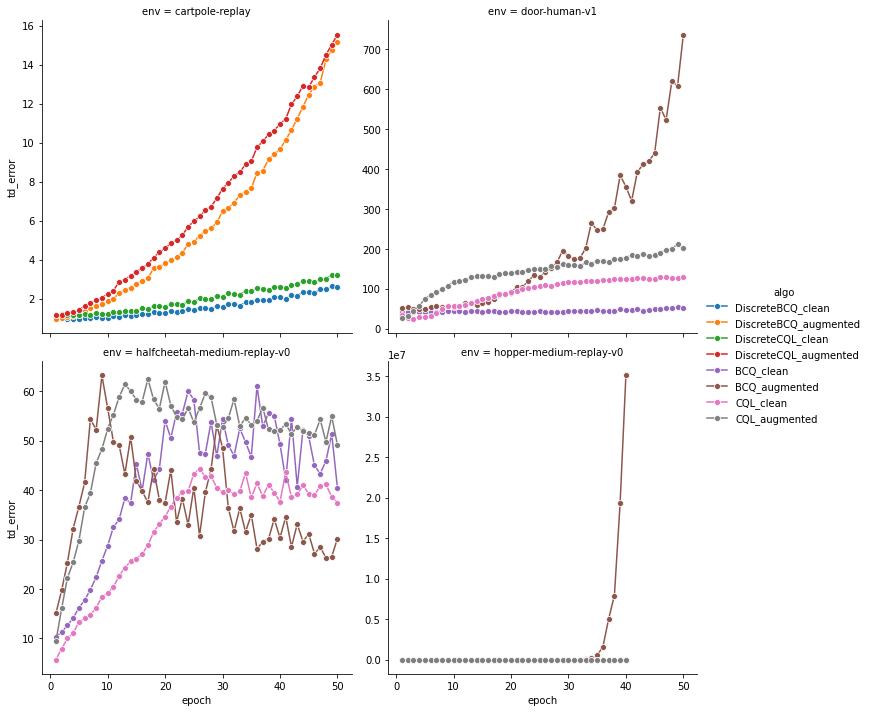

In [7]:
results_td = results_df[["env", "algo", "epoch", "td_error"]].dropna()
g = sns.FacetGrid(
    results_td,
    col="env",
    hue="algo",
    col_wrap=2,
    height=5,
    legend_out=True,
    sharey=False,
)
g.map_dataframe(sns.lineplot, "epoch", "td_error", marker="o")
g.add_legend()

### Expected value

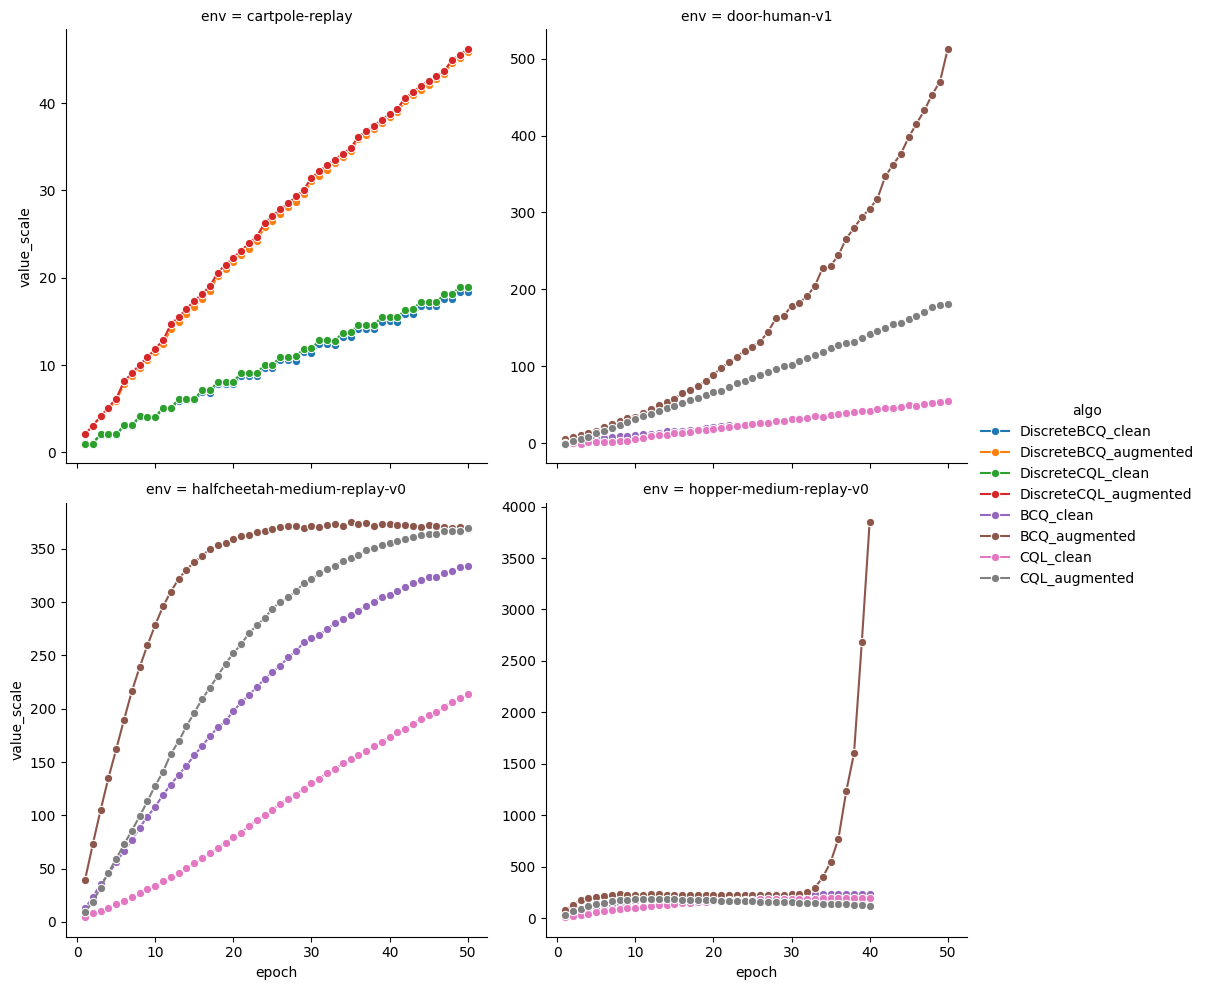

In [8]:
results_value = results_df[["env", "algo", "epoch", "value_scale"]].dropna()
g = sns.FacetGrid(
    results_value,
    col="env",
    hue="algo",
    col_wrap=2,
    height=5,
    legend_out=True,
    sharey=False,
)
g.map_dataframe(sns.lineplot, "epoch", "value_scale", marker="o")
g.add_legend()

### Environment reward

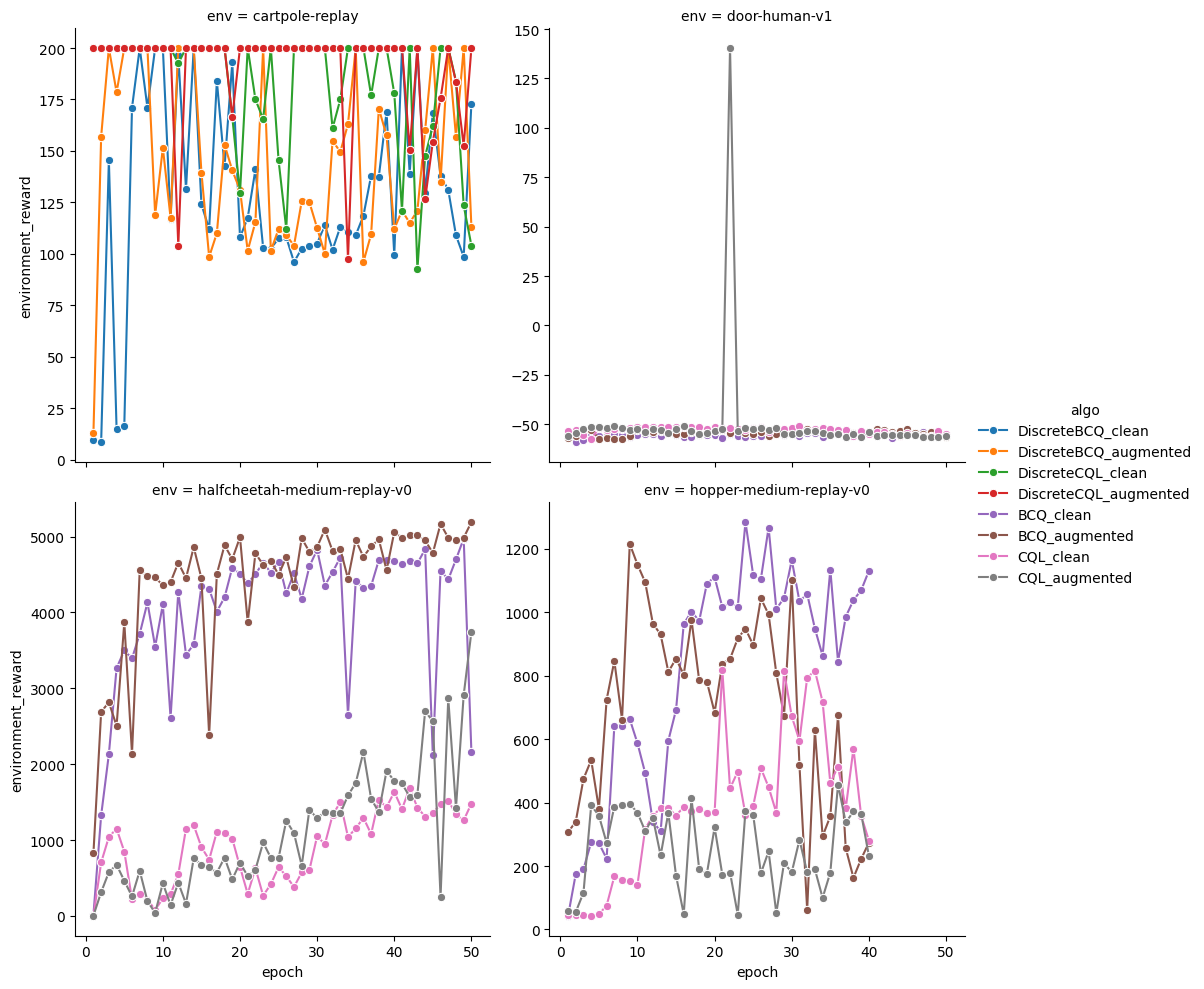

In [9]:
results_reward = results_df[["env", "algo", "epoch", "environment_reward"]].dropna()
g = sns.FacetGrid(
    results_reward,
    col="env",
    hue="algo",
    col_wrap=2,
    height=5,
    legend_out=True,
    sharey=False,
)
g.map_dataframe(sns.lineplot, "epoch", "environment_reward", marker="o")
g.add_legend()

### Advantage

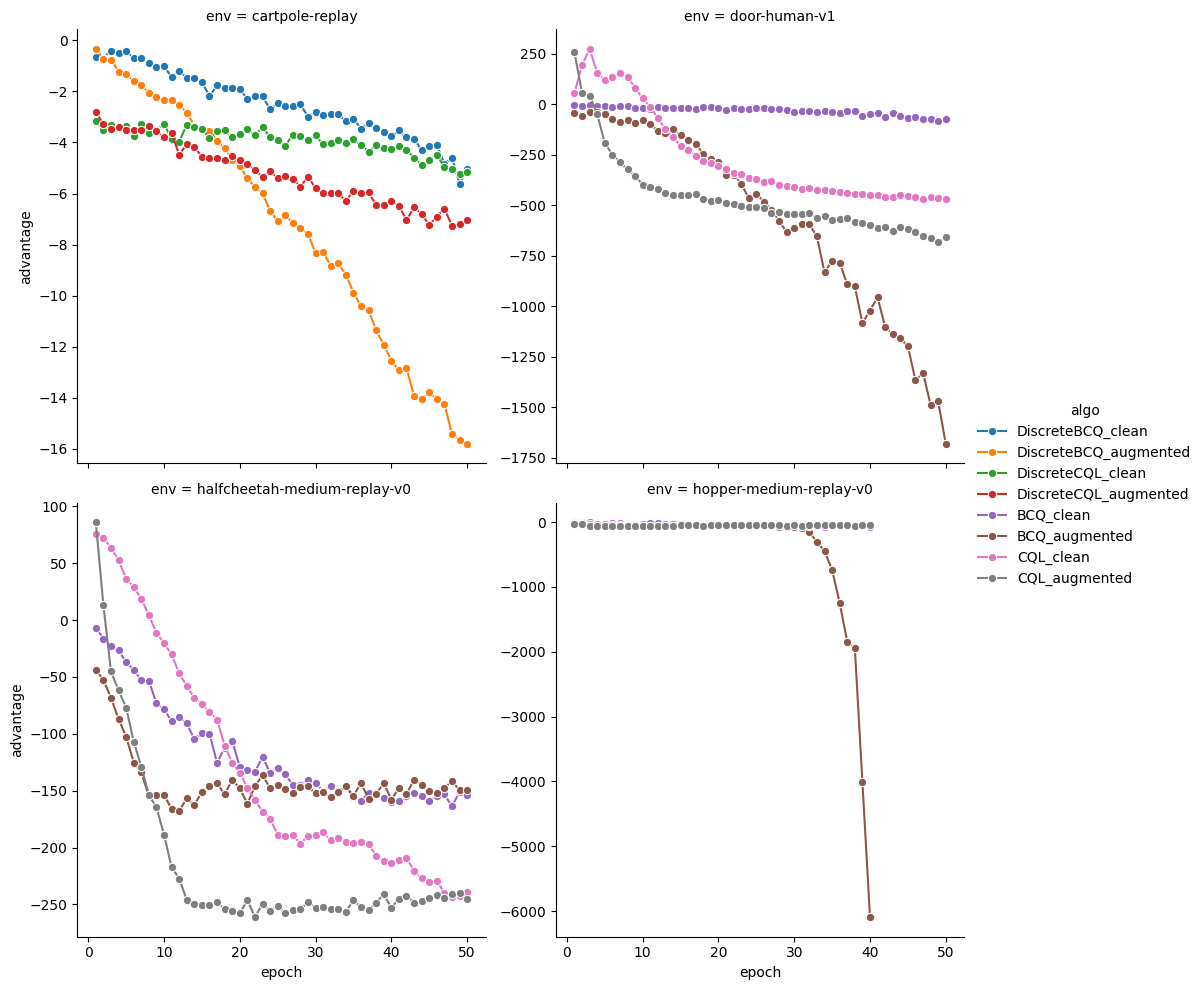

In [17]:
results_advantage = results_df[["env", "algo", "epoch", "advantage"]].dropna()
g = sns.FacetGrid(
    results_advantage,
    col="env",
    hue="algo",
    col_wrap=2,
    height=5,
    legend_out=True,
    sharey=False,
)
g.map_dataframe(sns.lineplot, "epoch", "advantage", marker="o")
g.add_legend()